In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import pandas_udf,PandasUDFType, sum, max, col, concat, lit
import sys
import os

from fbprophet import Prophet
import pandas as pd
import numpy as np

In [3]:
spark = SparkSession.builder.master('local[*]').appName('bigdata').getOrCreate()


In [4]:
schema = StructType([
    StructField("date_obs", DateType(), nullable=True),
    StructField("code_insee_departement", StringType(), nullable=True),
    StructField("departement", StringType(), nullable=True),
    StructField("tmin", FloatType(), nullable=True),
    StructField("tmax", FloatType(), nullable=True),
    StructField("tmoy", FloatType(), nullable=True)]
)

In [5]:
 df = spark.read.csv("C:/Users/user/Desktop/aisyah.csv",header = 'true',schema = schema)
    

In [6]:
df.show()

+----------+----------------------+---------------+-----+-----+-----+
|  date_obs|code_insee_departement|    departement| tmin| tmax| tmoy|
+----------+----------------------+---------------+-----+-----+-----+
|2018-04-15|                    23|         Creuse|  1.5| 17.8| 9.65|
|2018-04-15|                    24|       Dordogne| 3.45| 20.2|11.82|
|2018-04-15|                    30|           Gard|  7.9|18.73|13.32|
|2018-04-15|                    35|Ille-et-Vilaine|  8.4|16.55|12.48|
|2018-04-15|                    37| Indre-et-Loire|  7.2| 18.3|12.75|
|2018-04-15|                    49| Maine-et-Loire|  8.2| 17.1|12.65|
|2018-04-15|                    86|         Vienne|  7.0| 17.9|12.45|
|2018-04-15|                    63|    Puy-de-Dôme|  4.0| 19.5|11.75|
|2018-04-15|                    45|         Loiret|  6.4| 18.3|12.35|
|2018-04-15|                    79|    Deux-Sèvres|  6.7| 17.6|12.15|
|2018-04-15|                    43|    Haute-Loire|  5.9| 17.2|11.55|
|2018-04-15|        

In [7]:
df.printSchema()

root
 |-- date_obs: date (nullable = true)
 |-- code_insee_departement: string (nullable = true)
 |-- departement: string (nullable = true)
 |-- tmin: float (nullable = true)
 |-- tmax: float (nullable = true)
 |-- tmoy: float (nullable = true)



In [8]:
from pyspark.sql import functions as F
#show null values
df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).show()

+--------+----------------------+-----------+----+----+----+
|date_obs|code_insee_departement|departement|tmin|tmax|tmoy|
+--------+----------------------+-----------+----+----+----+
|       0|                     0|          0|   0|   0|   0|
+--------+----------------------+-----------+----+----+----+



In [10]:
# Select the subset data from 2019 to 2020
df = df.filter(df.departement == 'Dordogne')

df = df.filter((df.date_obs >= '2019-01-01') & (df.date_obs <= '2020-12-31'))



In [11]:
from pyspark.sql import functions as F
expr = [F.last(col).alias(col) for col in df.columns]

df.agg(*expr).show()


+----------+----------------------+-----------+----+----+----+
|  date_obs|code_insee_departement|departement|tmin|tmax|tmoy|
+----------+----------------------+-----------+----+----+----+
|2020-12-09|                    24|   Dordogne|-2.5| 8.1| 2.8|
+----------+----------------------+-----------+----+----+----+



In [12]:
df_panda = df.toPandas()


In [13]:
# show the dataframe columns
df.columns

['date_obs', 'code_insee_departement', 'departement', 'tmin', 'tmax', 'tmoy']

In [14]:
df.head(5)

[Row(date_obs=datetime.date(2019, 11, 14), code_insee_departement='24', departement='Dordogne', tmin=5.550000190734863, tmax=10.75, tmoy=8.149999618530273),
 Row(date_obs=datetime.date(2019, 10, 25), code_insee_departement='24', departement='Dordogne', tmin=9.399999618530273, tmax=19.450000762939453, tmoy=14.420000076293945),
 Row(date_obs=datetime.date(2019, 12, 2), code_insee_departement='24', departement='Dordogne', tmin=4.050000190734863, tmax=7.849999904632568, tmoy=5.949999809265137),
 Row(date_obs=datetime.date(2019, 11, 2), code_insee_departement='24', departement='Dordogne', tmin=13.300000190734863, tmax=18.049999237060547, tmoy=15.680000305175781),
 Row(date_obs=datetime.date(2019, 12, 4), code_insee_departement='24', departement='Dordogne', tmin=-2.5, tmax=12.75, tmoy=5.119999885559082)]

<AxesSubplot:xlabel='date_obs'>

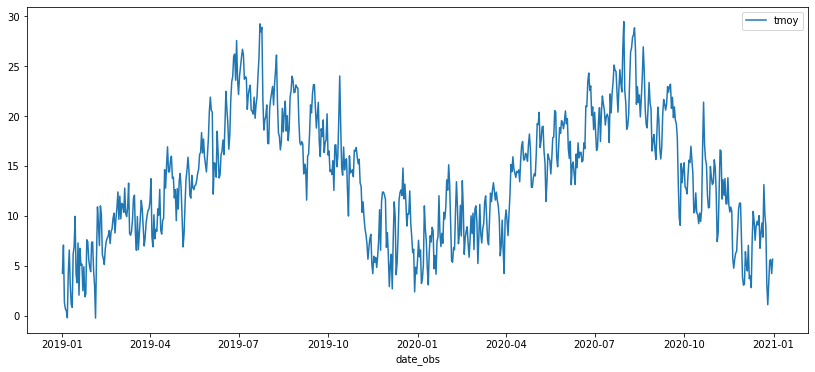

In [15]:
df_panda.plot(x = 'date_obs',y='tmoy',figsize=(14, 6))

In [16]:
from pyspark.sql.functions import percent_rank
from pyspark.sql import Window

df = df.withColumn("rank", percent_rank().over(Window.partitionBy().orderBy("date_obs")))

In [20]:
train_df = df.where("rank <= .8").drop("rank")
train_df.show()

+----------+----------------------+-----------+-----+-----+-----+
|  date_obs|code_insee_departement|departement| tmin| tmax| tmoy|
+----------+----------------------+-----------+-----+-----+-----+
|2019-01-01|                    24|   Dordogne|-1.45|  9.9| 4.23|
|2019-01-02|                    24|   Dordogne| 3.95| 10.2| 7.07|
|2019-01-03|                    24|   Dordogne| -5.7| 8.35| 1.32|
|2019-01-04|                    24|   Dordogne| -6.2| 7.55| 0.68|
|2019-01-05|                    24|   Dordogne|-6.45|  7.4| 0.48|
|2019-01-06|                    24|   Dordogne| -5.0| 4.55|-0.22|
|2019-01-07|                    24|   Dordogne| 2.35| 6.25|  4.3|
|2019-01-08|                    24|   Dordogne| 4.55|  8.6| 6.57|
|2019-01-09|                    24|   Dordogne| -0.6|  6.8|  3.1|
|2019-01-10|                    24|   Dordogne|-2.85| 5.15| 1.15|
|2019-01-11|                    24|   Dordogne|-4.55|  6.2| 0.82|
|2019-01-12|                    24|   Dordogne| 4.15| 8.15| 6.15|
|2019-01-1

In [21]:
test_df = df.where("rank > .8").drop("rank")
test_df.show()

+----------+----------------------+-----------+-----+-----+-----+
|  date_obs|code_insee_departement|departement| tmin| tmax| tmoy|
+----------+----------------------+-----------+-----+-----+-----+
|2020-08-08|                    24|   Dordogne|18.75|34.95|26.85|
|2020-08-09|                    24|   Dordogne| 18.5|37.35|27.92|
|2020-08-10|                    24|   Dordogne| 20.5| 35.8|28.15|
|2020-08-11|                    24|   Dordogne|20.65|37.05|28.85|
|2020-08-12|                    24|   Dordogne|19.95|33.45| 26.7|
|2020-08-13|                    24|   Dordogne|17.25| 25.1|21.18|
|2020-08-14|                    24|   Dordogne|17.75|28.15|22.95|
|2020-08-15|                    24|   Dordogne| 12.7| 30.0|21.35|
|2020-08-16|                    24|   Dordogne|17.55| 26.7|22.12|
|2020-08-17|                    24|   Dordogne| 13.7|26.15|19.92|
|2020-08-18|                    24|   Dordogne| 15.1| 28.5| 21.8|
|2020-08-19|                    24|   Dordogne|14.45|33.35| 23.9|
|2020-08-2

In [17]:
history = df.drop(*('code_insee_departement','departement','tmin','tmax'))

history = df.selectExpr("date_obs as ds", "tmoy as y")

In [27]:
train = train_df.drop(*('code_insee_departement','departement','tmin','tmax'))

train = train.selectExpr("date_obs as ds", "tmoy as y")

In [39]:
test = test_df.drop(*('code_insee_departement','departement','tmin','tmax'))

test = test_df.selectExpr("date_obs as ds", "tmoy as y")

testp = test.toPandas()

In [18]:
history.show()

+----------+-----+
|        ds|    y|
+----------+-----+
|2019-11-14| 8.15|
|2019-10-25|14.42|
|2019-12-02| 5.95|
|2019-11-02|15.68|
|2019-12-04| 5.12|
|2019-12-09| 9.93|
|2019-12-12| 7.98|
|2019-12-15|12.59|
|2019-12-16|12.04|
|2019-11-18| 5.35|
|2020-05-22| 20.4|
|2019-11-20| 4.82|
|2019-11-22| 7.52|
|2019-11-24| 6.55|
|2020-05-28|19.55|
|2019-11-26|12.38|
|2019-12-31| 4.18|
|2020-01-01| 5.57|
|2019-12-03|  2.9|
|2020-06-04| 16.7|
+----------+-----+
only showing top 20 rows



In [20]:
history_pd = history.toPandas()

In [21]:
import pandas as pd
from fbprophet import Prophet

# instantiate the model and set parameters
model = Prophet()

# fit the model to historical data
model.fit(history_pd)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [22]:
# define a dataset including both historical dates & 90-days beyond the last available date, using Prophet's built-in make_future_dataframe method
future_pd = model.make_future_dataframe(
    periods=90, 
    freq='d', 
    include_history=True
)
 
# predict over the dataset
forecast_pd = model.predict(future_pd)


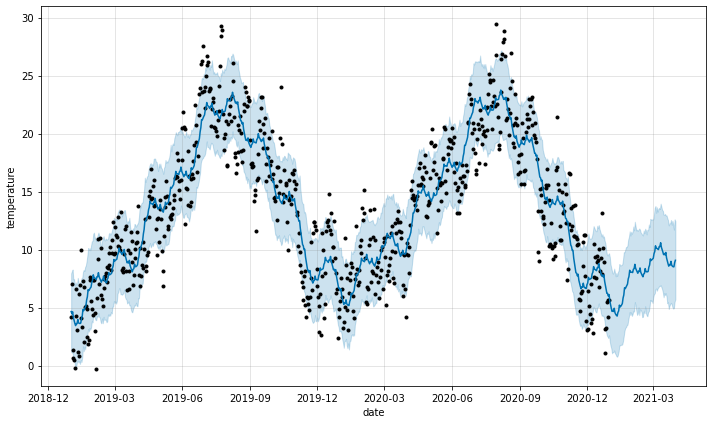

In [25]:
predict_fig = model.plot(forecast_pd, xlabel='date', ylabel='temperature')

In [53]:
df_panda = df_panda.rename(columns={'date_obs': 'ds'})

In [56]:
df_panda

,ds,code_insee_departement,departement,tmin,tmax,tmoy
0,2019-11-14,24,Dordogne,5.55,10.750000,8.15
1,2019-10-25,24,Dordogne,9.40,19.450001,14.42
2,2019-12-02,24,Dordogne,4.05,7.850000,5.95
3,2019-11-02,24,Dordogne,13.30,18.049999,15.68
4,2019-12-04,24,Dordogne,-2.50,12.750000,5.12
...,...,...,...,...,...,...
726,2020-11-20,24,Dordogne,0.20,11.300000,5.75
727,2020-11-21,24,Dordogne,-2.60,12.100000,4.75
728,2020-11-23,24,Dordogne,-1.85,14.350000,6.25
729,2020-11-27,24,Dordogne,4.30,18.250000,11.28


In [28]:
def forecast_department_temp(history_pd: pd.DataFrame) -> pd.DataFrame: 
    
    # instantiate the model, configure the parameters
    model = Prophet(
    )
    
    # fit the model
    model.fit(history_pd)
    
    # configure predictions
    future_pd = model.make_future_dataframe(
        periods=90, 
        freq='d',
        include_history=True
    )
    
    # make predictions
    results_pd = model.predict(future_pd)
    
    # . . .
    
    # return predictions
    return results_pd

In [47]:
df = df.drop(*('code_insee_departement','tmin','tmax','rank'))

df.show()

+----------+---------------+-----+
|  date_obs|    departement| tmoy|
+----------+---------------+-----+
|2018-04-15|         Creuse| 9.65|
|2018-04-15|       Dordogne|11.82|
|2018-04-15|           Gard|13.32|
|2018-04-15|Ille-et-Vilaine|12.48|
|2018-04-15| Indre-et-Loire|12.75|
|2018-04-15| Maine-et-Loire|12.65|
|2018-04-15|         Vienne|12.45|
|2018-04-15|    Puy-de-Dôme|11.75|
|2018-04-15|         Loiret|12.35|
|2018-04-15|    Deux-Sèvres|12.15|
|2018-04-15|    Haute-Loire|11.55|
|2018-04-15|   Corse-du-Sud|17.61|
|2018-04-15|  Haute-Garonne|12.81|
|2018-04-15|   Haute-Savoie| 12.6|
|2018-04-15|          Doubs| 13.4|
|2018-04-15|         Savoie|13.02|
|2018-04-15| Lot-et-Garonne| 13.2|
|2018-04-15|      Haut-Rhin|14.65|
|2018-04-15|           Tarn|13.05|
|2018-04-16|Hautes-Pyrénées|11.05|
+----------+---------------+-----+
only showing top 20 rows



In [51]:
df.select(['departement']).groupby('departement').agg({'departement': 'count'}).show()


df.createOrReplaceTempView("temp")

spark.sql("select departement, count(*) from temp group by departement order by departement").show()


+-------------------+------------------+
|        departement|count(departement)|
+-------------------+------------------+
|Pyrénées-Orientales|              1461|
|               Gers|              1461|
|             Allier|              1461|
|              Yonne|              1461|
|              Drôme|              1461|
|     Indre-et-Loire|              1461|
|   Bouches-du-Rhône|              1462|
|          Finistère|              1461|
|            Aveyron|              1461|
|               Gard|              1461|
|         Val-d'Oise|              1462|
|               Eure|              1461|
|  Seine-Saint-Denis|              1461|
|              Indre|              1461|
|               Nord|              1461|
| Meurthe-et-Moselle|              1461|
|             Lozère|              1461|
|               Jura|              1461|
|           Calvados|              1461|
|     Seine-Maritime|              1461|
+-------------------+------------------+
only showing top

In [54]:
df.show()

+----------+---------------+-----+
|  date_obs|    departement| tmoy|
+----------+---------------+-----+
|2018-04-15|         Creuse| 9.65|
|2018-04-15|       Dordogne|11.82|
|2018-04-15|           Gard|13.32|
|2018-04-15|Ille-et-Vilaine|12.48|
|2018-04-15| Indre-et-Loire|12.75|
|2018-04-15| Maine-et-Loire|12.65|
|2018-04-15|         Vienne|12.45|
|2018-04-15|    Puy-de-Dôme|11.75|
|2018-04-15|         Loiret|12.35|
|2018-04-15|    Deux-Sèvres|12.15|
|2018-04-15|    Haute-Loire|11.55|
|2018-04-15|   Corse-du-Sud|17.61|
|2018-04-15|  Haute-Garonne|12.81|
|2018-04-15|   Haute-Savoie| 12.6|
|2018-04-15|          Doubs| 13.4|
|2018-04-15|         Savoie|13.02|
|2018-04-15| Lot-et-Garonne| 13.2|
|2018-04-15|      Haut-Rhin|14.65|
|2018-04-15|           Tarn|13.05|
|2018-04-16|Hautes-Pyrénées|11.05|
+----------+---------------+-----+
only showing top 20 rows



In [66]:
df = df.filter((df.date_obs >= '2019-01-01') & (df.date_obs <= '2020-12-31'))

df_prl = df.groupBy('departement').count()

In [67]:
df_prl.show()

+-------------------+-----+
|        departement|count|
+-------------------+-----+
|Pyrénées-Orientales|  731|
|               Gers|  731|
|              Yonne|  731|
|             Allier|  731|
|              Drôme|  731|
|     Indre-et-Loire|  731|
|   Bouches-du-Rhône|  731|
|          Finistère|  731|
|            Aveyron|  731|
|               Gard|  731|
|         Val-d'Oise|  732|
|               Eure|  731|
|              Indre|  731|
|  Seine-Saint-Denis|  731|
|               Nord|  731|
| Meurthe-et-Moselle|  731|
|             Lozère|  731|
|           Calvados|  731|
|               Jura|  731|
|     Seine-Maritime|  731|
+-------------------+-----+
only showing top 20 rows



In [73]:
df.createOrReplaceTempView("df")
spark.sql("select departement, count(*) from df group by departement order by departement").show()

+--------------------+--------+
|         departement|count(1)|
+--------------------+--------+
|                 Ain|     731|
|               Aisne|     731|
|              Allier|     731|
|     Alpes-Maritimes|     731|
|Alpes-de-Haute-Pr...|     731|
|            Ardennes|     731|
|             Ardèche|     731|
|              Ariège|     731|
|                Aube|     731|
|                Aude|     731|
|             Aveyron|     731|
|            Bas-Rhin|     731|
|    Bouches-du-Rhône|     731|
|            Calvados|     731|
|              Cantal|     731|
|            Charente|     731|
|   Charente-Maritime|     731|
|                Cher|     731|
|             Corrèze|     731|
|        Corse-du-Sud|     731|
+--------------------+--------+
only showing top 20 rows



In [83]:
sql = "SELECT departement, date_obs as ds, sum(tmoy) as y FROM df GROUP BY departement, ds ORDER BY departement, ds"
df2 = spark.sql(sql)

In [84]:
df2.show()

+-----------+----------+-------------------+
|departement|        ds|                  y|
+-----------+----------+-------------------+
|        Ain|2019-01-01|               5.75|
|        Ain|2019-01-02|  4.050000190734863|
|        Ain|2019-01-03|0.44999998807907104|
|        Ain|2019-01-04|  0.550000011920929|
|        Ain|2019-01-05| 0.3499999940395355|
|        Ain|2019-01-06|  2.049999952316284|
|        Ain|2019-01-07|               2.75|
|        Ain|2019-01-08|  2.450000047683716|
|        Ain|2019-01-09|               1.75|
|        Ain|2019-01-10| 2.0999999046325684|
|        Ain|2019-01-11| 0.3499999940395355|
|        Ain|2019-01-12|  2.450000047683716|
|        Ain|2019-01-13|  4.349999904632568|
|        Ain|2019-01-14|  5.800000190734863|
|        Ain|2019-01-15| 3.3499999046325684|
|        Ain|2019-01-16|  3.049999952316284|
|        Ain|2019-01-17|  6.150000095367432|
|        Ain|2019-01-18|               0.75|
|        Ain|2019-01-19| -1.899999976158142|
|        A

In [86]:
from pyspark.sql.types import *
result_schema = StructType([
                  StructField('ds', DateType()),
                  StructField('departement', IntegerType()),
                  StructField('y', DoubleType()),
                  StructField('yhat', DoubleType()),
                  StructField('yhat_upper', DoubleType()),
                  StructField('yhat_lower', DoubleType())
])

In [96]:
import os
os.environ["ARROW_PRE_0_15_IPC_FORMAT"] = "1"

spark.conf.set("spark.sql.execution.arrow.enabled", "true")
